**Constante pentru configuratie**

In [1]:
data_path = "/kaggle/input/nitro-lang-processing-1/" # basepath-ul pentru date

**Modelele de SpaCy pentru limba Romana**

In [2]:
!pip install pytictoc

In [3]:
!pip install -U 'spacy[cuda110]'

     |████████████████████████████████| 76.9 MB 58.2 MB/s            
     |████████████████████████████████| 47 kB 2.7 MB/s             
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
tensorflow 2.6.2 requires numpy~=1.19.2, but you have numpy 1.20.3 which is incompatible.
tensorflow 2.6.2 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.2 requires typing-extensions~=3.7.4, but you have typing-extensions 3.10.0.2 which is incompatible.
tensorflow 2.6.2 requires wrapt~

In [4]:
!python -m spacy download ro_core_news_sm
!python -m spacy download ro_core_news_lg

     |████████████████████████████████| 16.6 MB 5.0 MB/s            
✔ Download and installation successful
You can now load the package via spacy.load('ro_core_news_sm')
     |████████████████████████████████| 572.3 MB 19 kB/s               
✔ Download and installation successful
You can now load the package via spacy.load('ro_core_news_lg')


In [29]:
!pip install spacy-transformers

     |████████████████████████████████| 51 kB 82 kB/s              
     |████████████████████████████████| 1.1 MB 9.6 MB/s            


In [6]:
!python -m spacy download ro_ner


✘ No compatible package found for 'ro_ner' (spaCy v3.2.3)



**Toate import-urile intr-o celula ca sa nu avem probleme cu random_state-ul**

In [10]:
seed = 46

from pytictoc import TicToc

import numpy as np
np.random.seed(seed)
np.random.RandomState(seed)

#import cupy as cp
#cp.random.seed(seed)
#cp.random.RandomState(seed)

import random
random.seed(seed)

import torch
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)

import pandas as pd
import spacy
from spacy.tokens import Doc
from spacy.training import Example
#import spacy_sentence_bert

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import itertools
from collections import Counter
import matplotlib.pyplot as plt

import seaborn as sns

#spacy.prefer_gpu()

In [11]:
nlp_small = spacy.load("ro_core_news_lg")

In [12]:
df = pd.read_json(f"{data_path}/train.json")

**Inlocuim tokenizer-ul de la spacy cu tokenizarea pe care o avem deja**

In [13]:
# https://spacy.io/usage/linguistic-features#native-tokenizers
class PremadeTokenizer:
    def __init__(self, vocab, premade_tokens, premade_spaces):
        self.vocab = vocab
        self.premade_tokens = premade_tokens
        self.premade_spaces = premade_spaces

    def __call__(self, text_id):
        text_id = int(text_id)
        # little hack here, we pass the index of the text and return df["tokens"][index]
        return Doc(self.vocab, words=self.premade_tokens[text_id], spaces=self.premade_spaces[text_id])

In [14]:
# convertire label-uri spacy (nlp.get_pipe('ner').labels) in label-urile noastre
label_mapping = {
    "": 0,
    "DATETIME": 9,
    "EVENT": 6,
    "FACILITY": 15,
    "GPE": 3,
    "LANGUAGE": 7,
    "LOC": 4,
    "MONEY": 11,
    "NAT_REL_POL": 5,
    "NUMERIC_VALUE": 13,
    "ORDINAL": 14,
    "ORGANIZATION": 2,
    "PERIOD": 10,
    "PERSON": 1,
    "QUANTITY": 12,
    "WORK_OF_ART": 8
}

reverse_label_mapping = {v: k for k, v in label_mapping.items()}

**Procesam toate datele (NER e inclus in pipeline-ul default)**

In [63]:
def spacy_process(nlp, tokens, space_after):
    nlp.tokenizer = PremadeTokenizer(nlp.vocab, tokens, space_after)
    tokenized = []

    with nlp.select_pipes(enable=["tokenizer", "ner"]):
        for i, doc in enumerate(nlp.pipe(map(str, range(len(tokens))), batch_size=1000)):
            tokenized.append(doc)

            if i % 1000 == 0: print(f"Progress {i}/{len(tokens)}")
            assert len(doc) == len(tokens[i])

        return tokenized
        
processed_texts = spacy_process(nlp_small, df["tokens"], df["space_after"])

Progress 0/12330
Progress 1000/12330
Progress 2000/12330
Progress 3000/12330
Progress 4000/12330
Progress 5000/12330
Progress 6000/12330
Progress 7000/12330
Progress 8000/12330
Progress 9000/12330
Progress 10000/12330
Progress 11000/12330
Progress 12000/12330


In [49]:
processed_texts[0], processed_texts[0][8].ent_type_

(În România, ca de altfel în întreaga Europă, stand up-ul este forma de divertisment cea mai îndrăgită de tineri în acest moment, comediantii reușind să umple săli care erau destinate mai degrabă artiștilor din zona muzicii pop rock, iar Badea, Bordea și Micutzu sunt printre cei care au contribuit direct la succesul acestei forme de divertisment în țara noastră.,
 'LOC')

**Verificam acuratetea modelului de baza pe tot setul de train**

In [50]:
from pprint import pprint

def eval_predicts(texts):
    correct = 0
    wrong = 0

    y_pred = []
    unk = set()

    for i, doc in enumerate(texts):
        for j, tk in enumerate(doc):
            if tk.ent_type_ not in label_mapping:
                #print(i, j, tk, tk.ent_type_)
                prediction = 0
                unk.add(tk.ent_type_)
            else:
                prediction = label_mapping[tk.ent_type_]

            y_pred.append(prediction)
    #print(unk)
    return y_pred

def report(texts, labels):
    y_pred = eval_predicts(texts)
    y_true = labels
    print (classification_report(y_pred, y_true))
    cm = confusion_matrix(y_pred, y_true)
    pprint(cm)
    
def acc_score(texts, labels):
    y_pred = eval_predicts(texts)
    y_true = labels
    return accuracy_score(y_pred, y_true)

report(processed_texts, list(itertools.chain(*df["ner_ids"])))
print(acc_score(processed_texts, list(itertools.chain(*df["ner_ids"]))))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95    417576
           1       0.75      0.86      0.80     34404
           2       0.78      0.66      0.72     23842
           3       0.86      0.78      0.82     14019
           4       0.54      0.64      0.59      4639
           5       0.79      0.87      0.83      4595
           6       0.54      0.59      0.56      3299
           7       0.51      0.85      0.63       400
           8       0.17      0.39      0.24      3133
           9       0.88      0.88      0.88     21351
          10       0.58      0.84      0.69      2522
          11       0.95      0.94      0.94      4124
          12       0.56      0.82      0.66      1825
          13       0.86      0.81      0.84      8541
          14       0.78      0.84      0.81      2851
          15       0.55      0.31      0.39      6042

    accuracy                           0.90    553163
   macro avg       0.69   

**Impartin datele in train, validation si test. Verificam ca distributia token-urilor e uniforma**

In [19]:
X, y = list(zip(df["tokens"], df["space_after"])), list(df["ner_ids"])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=seed, shuffle=True)

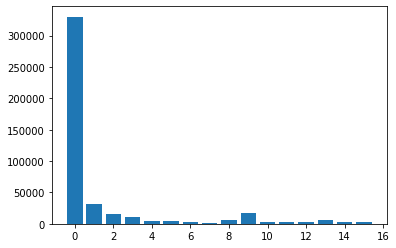

[(0, 74.47122445802621), (1, 7.12118238159376), (9, 3.8660683465654127), (2, 3.689415013502812), (3, 2.3100299836883322), (13, 1.459025676776291), (8, 1.2494331526190041), (4, 1.0226942002206474), (5, 0.9250046814261316), (11, 0.7600831150547895), (10, 0.6955583982528691), (6, 0.6594606545874593), (15, 0.6161433621889671), (14, 0.5559052524473143), (12, 0.476715827281321), (7, 0.1220554957686676)]


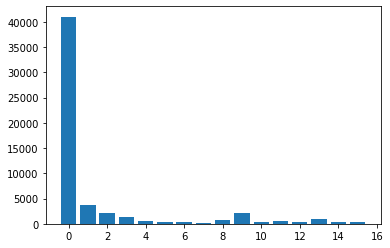

[(0, 74.5960192674725), (1, 6.718167772425702), (2, 3.855312187585204), (9, 3.72625647550668), (3, 2.450240843406344), (13, 1.5722984640552575), (8, 1.5177678814868671), (4, 0.8761246932654729), (11, 0.8434063437244389), (5, 0.7852403889848224), (15, 0.6816322821048805), (6, 0.6670907934199763), (14, 0.5616650004544216), (12, 0.5471235117695175), (10, 0.48895755702990096), (7, 0.11269653730800691)]


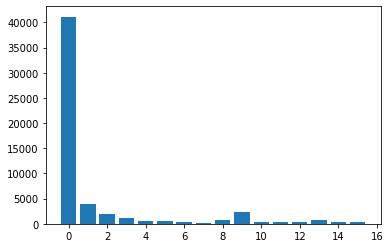

[(0, 74.9266942284226), (1, 7.326934634928151), (9, 4.108765731145391), (2, 3.4531116251115526), (3, 2.223760176298104), (8, 1.3586610086145665), (13, 1.2730617225490375), (5, 0.9634472835886134), (4, 0.9434134081264685), (6, 0.6101225708926002), (10, 0.5937312182417542), (14, 0.5664122971570109), (15, 0.5372721146666182), (12, 0.5099531935818749), (11, 0.4826342724971315), (7, 0.12202451417852003)]


(None, None, None)

In [20]:
def plot_tokens_hist(y):
    tokens_all = list(itertools.chain(*y))
    w = Counter(tokens_all)
    
    plt.bar(w.keys(), w.values())
    plt.show()
    print(sorted([(i, w[i] / len(tokens_all) * 100.0) for i in w], key=lambda x: -x[1]))

plot_tokens_hist(y_train), plot_tokens_hist(y_val), plot_tokens_hist(y_test)

**Reantrenam modelul de la spacy**

In [60]:
from thinc.api import Config
from spacy.language import Language

config = Config().from_bytes(b"""
# This is an auto-generated partial config. To use it with 'spacy train'
# you can run spacy init fill-config to auto-fill all default settings:
# python -m spacy init fill-config ./base_config.cfg ./config.cfg
[paths]
train = null
dev = null
vectors = "ro_core_news_lg"
[system]
gpu_allocator = null

[nlp]
lang = "ro"
pipeline = ["ner"]
batch_size = 1000

[components]

[components.ner]
factory = "ner"

[components.ner.model]
@architectures = "spacy.TransitionBasedParser.v2"
state_type = "ner"
extra_state_tokens = false
hidden_width = 64
maxout_pieces = 2
use_upper = true
nO = null

[corpora]

[corpora.train]
@readers = "spacy.Corpus.v1"
path = ${paths.train}
max_length = 0

[corpora.dev]
@readers = "spacy.Corpus.v1"
path = ${paths.dev}
max_length = 0

[training]
dev_corpus = "corpora.dev"
train_corpus = "corpora.train"

[training.optimizer]
@optimizers = "Adam.v1"

[training.batcher]
@batchers = "spacy.batch_by_words.v1"
discard_oversize = false
tolerance = 0.2

[training.batcher.size]
@schedules = "compounding.v1"
start = 100
stop = 1000
compound = 1.001

[initialize]
vectors = ${paths.vectors}
""")
nlp_small_trainable = spacy.load("ro_core_news_lg").from_config(config)

In [21]:
#nlp_small_trainable = spacy.load("ro_core_news_lg")

In [61]:
def rejoin(tokens, space_after):
    l = []
    for t, s in zip(tokens, space_after):
        l.append(t)
        if s: l.append(' ')
    return ''.join(l)

def to_example(nlp, tokens, space_after, ner_ids):
    text = rejoin(tokens, space_after)
    entities = []
    
    i = 0
    for tk_id, tk in enumerate(tokens):
        start = text.index(tk, i)
        end = start + len(tk)
        i = end
        
        if ner_ids[tk_id] != 0:
            entities.append((start, end, reverse_label_mapping[ner_ids[tk_id]]))
        
    doc = Doc(nlp.vocab, words=tokens, spaces=space_after)
    example = Example.from_dict(doc, {"entities": entities})
    return example
    
print(to_example(nlp_small_trainable, df["tokens"][0], df["space_after"][0], df["ner_ids"][0]))
print (df["tokens"][0])
print (df["ner_tags"][0])

{'doc_annotation': {'cats': {}, 'entities': ['O', 'U-GPE', 'O', 'O', 'O', 'O', 'O', 'O', 'U-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'U-PERSON', 'O', 'O', 'O', 'O', 'U-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'U-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'U-PERSON', 'O', 'U-PERSON', 'O', 'U-PERSON', 'O', 'O', 'U-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], 'links': {}}, 'token_annotation': {'ORTH': ['În', 'România', ',', 'ca', 'de', 'altfel', 'în', 'întreaga', 'Europă', ',', 'stand', 'up', '-ul', 'este', 'forma', 'de', 'divertisment', 'cea', 'mai', 'îndrăgită', 'de', 'tineri', 'în', 'acest', 'moment', ',', 'comediantii', 'reușind', 'să', 'umple', 'săli', 'care', 'erau', 'destinate', 'mai', 'degrabă', 'artiștilor', 'din', 'zona', 'muzicii', 'pop', 'rock', ',', 'iar', 'Badea', ',', 'Bordea', 'și', 'Micutzu', 'sunt', 'printre', 'cei', 'care', 'au', 'contribuit', 'direct', 'la', 'succesul', 'acestei', 'forme', 'de', 

In [54]:
def prepare_train_data(nlp, X_train, y_train):
    prepared = []
    
    for i in range(len(X_train)):
        if i % 1000 == 0: print(f"progress {i}/{len(X_train)}")
        prepared.append(to_example(nlp, X_train[i][0], X_train[i][1], y_train[i]))
    
    return prepared

prepared = prepare_train_data(nlp_small_trainable, X_train, y_train)

progress 0/9864
progress 1000/9864
progress 2000/9864
progress 3000/9864
progress 4000/9864
progress 5000/9864
progress 6000/9864
progress 7000/9864
progress 8000/9864
progress 9000/9864


In [62]:
def train_spacy_ner(nlp, data, X_val = None, y_val = None, epochs=10, batch_size=1024):
    t = TicToc()
    acc = 0
    optimizer = nlp.initialize()
    with nlp.select_pipes(enable=["tokenizer", "ner"]):
        accs = []

        if y_val is not None:
            y_val_flat = list(itertools.chain(*y_val))
            processed_texts = spacy_process(nlp, [x[0] for x in X_val], [x[1] for x in X_val])
            acc = acc_score(processed_texts, y_val_flat)
            print(f"Pretrain val acc {acc}")

        for i in range(epochs):
            print(f"Epoch {i}")
            for j in range(0, len(data), batch_size):
                batch = data[j:j+batch_size]
                t.tic()
                losses = nlp.update(batch,sgd=optimizer)
                t.toc("Updated weights")
                print(f"Losses {losses}")

            if y_val is not None:
                processed_texts = spacy_process(nlp, [x[0] for x in X_val], [x[1] for x in X_val])
                acc = acc_score(processed_texts, y_val_flat)
                print(f"Val acc {acc}")

            accs.append(acc)


In [67]:

# Platou dupa ~10 epoci
accs = train_spacy_ner(nlp_small_trainable, prepared, X_val, y_val, epochs=20)

[2022-03-26 23:47:05,164] [INFO] Created vocabulary
[2022-03-26 23:47:08,775] [INFO] Added vectors: ro_core_news_lg
[2022-03-26 23:47:11,376] [INFO] Finished initializing nlp object


Progress 0/1233
Progress 1000/1233
Pretrain val acc 0.745960192674725
Epoch 0
Updated weights 15.441323 seconds.
Losses {'ner': 46029.4284362793}
Updated weights 7.335144 seconds.
Losses {'ner': 44548.07755470276}
Updated weights 7.407873 seconds.
Losses {'ner': 44997.11430120468}
Updated weights 8.268937 seconds.
Losses {'ner': 45760.10919189453}
Updated weights 7.156758 seconds.
Losses {'ner': 41411.819296479225}
Updated weights 7.231087 seconds.
Losses {'ner': 39690.75811100006}
Updated weights 7.500229 seconds.
Losses {'ner': 35827.7106552124}
Updated weights 7.126651 seconds.
Losses {'ner': 27523.276873588562}
Updated weights 7.360138 seconds.
Losses {'ner': 20560.20832824707}
Updated weights 4.434011 seconds.
Losses {'ner': 11888.288018628955}
Progress 0/1233
Progress 1000/1233
Val acc 0.745960192674725
Epoch 1
Updated weights 7.498065 seconds.
Losses {'ner': 20036.851572752}
Updated weights 7.748712 seconds.
Losses {'ner': 20787.82048034668}
Updated weights 7.477614 seconds.
Los

KeyboardInterrupt: 

In [68]:
def model_report(nlp, X, y):
    processed_texts = spacy_process(nlp, [x[0] for x in X], [x[1] for x in X])
    report(processed_texts, list(itertools.chain(*y)))

In [69]:
model_report(nlp_small_trainable, X_val, y_val)

Progress 0/1233
Progress 1000/1233
              precision    recall  f1-score   support

           0       0.98      0.95      0.96     42310
           1       0.78      0.77      0.78      3719
           2       0.64      0.72      0.68      1895
           3       0.80      0.80      0.80      1338
           4       0.53      0.62      0.57       415
           5       0.73      0.82      0.77       383
           6       0.38      0.66      0.48       211
           7       0.77      0.96      0.86        50
           8       0.23      0.48      0.31       394
           9       0.88      0.92      0.90      1962
          10       0.74      0.66      0.70       301
          11       0.89      0.98      0.94       423
          12       0.77      0.88      0.82       264
          13       0.91      0.88      0.90       890
          14       0.88      0.86      0.87       315
          15       0.23      0.61      0.34       145

    accuracy                           0.91  

In [71]:
model_report(nlp_small_trainable, X_test, y_test)

Progress 0/1233
Progress 1000/1233
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     42296
           1       0.80      0.78      0.79      4133
           2       0.65      0.72      0.68      1727
           3       0.83      0.81      0.82      1257
           4       0.48      0.62      0.54       399
           5       0.65      0.84      0.73       408
           6       0.41      0.73      0.52       187
           7       0.64      0.81      0.72        53
           8       0.19      0.44      0.26       322
           9       0.87      0.92      0.89      2145
          10       0.70      0.65      0.68       352
          11       0.83      0.89      0.86       247
          12       0.74      0.82      0.78       253
          13       0.86      0.86      0.86       700
          14       0.82      0.89      0.86       285
          15       0.24      0.49      0.32       143

    accuracy                           0.91  

**Pregatire submisie cu modelul preantrenat (88% pe toate de train) si modelul reantrenat (93% pe split-ul nostru de test)**

In [72]:
df_test = pd.read_json(f"{data_path}/test.json")

In [73]:
result_model_pretrained = spacy_process(nlp_small, df_test["tokens"], df_test["space_after"])

Progress 0/2421
Progress 1000/2421
Progress 2000/2421


In [ ]:
predicts = eval_predicts(result_model_pretrained)

In [ ]:
df_output_pretrained = pd.DataFrame({"ner_label": predicts})
open("/kaggle/working/result_model_pretrained_large.csv", "w").write('Id' + df_output_pretrained.to_csv(index=True))

In [74]:
result_model_custom = spacy_process(nlp_small_trainable, df_test["tokens"], df_test["space_after"])

Progress 0/2421
Progress 1000/2421
Progress 2000/2421


In [76]:
predicts = eval_predicts(result_model_custom)

In [77]:
df_custom = pd.DataFrame({"ner_label": predicts})
open("/kaggle/working/result_model_custom.csv", "w").write('Id' + df_custom.to_csv(index=True))

577400

**Modelul LARGE si reantrenat pe tot setul de date**

In [ ]:
prepared_full = prepare_train_data(nlp_small_trainable, X, y)

In [ ]:
train_spacy_ner(nlp_small_trainable, prepared_full, epochs=1)

In [ ]:
result_all_data = spacy_process(nlp_small_trainable, df_test["tokens"], df_test["space_after"])

In [ ]:
predicts = eval_predicts(result_all_data)
df_all_data = pd.DataFrame({"ner_label": predicts})
open("/kaggle/working/result_all_data.csv", "w").write('Id' + df_all_data.to_csv(index=True))